In [3]:
## initialization 1214

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 
import warnings

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
[vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']
# set the style of the plots
az.style.use("arviz-white")
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

# Bayesian In Serial Dependence

在强化学习的模型中，我们没有办法看见经典的，且在行为上明显的知觉的serial dependence。表明在知觉过程仍然需要贝叶斯推理来形成相对连续的表征。


# 1. Bimodal Prior Update

## 1.1. Mathematical Formulation

Based on SDT model, for a given stimulus $s_t$ in a noisy environment, the agent's perception $x_t$ is a noisy version of the stimulus $s_t$ with a Gaussian distribution: $$x_t \sim \mathcal{N}(s_t, \sigma^2)$$ where $\sigma$ is the standard deviation of the noise, it is the likelihood of the stimulus $s_t$ given the perception $x_t$:
$$p(x_t | s_t) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x_t - s_t)^2}{2\sigma^2}}$$

Since the stimulus $s_t$ is not directly observable, we need to infer it from the perception $x_t$. The posterior distribution of the stimulus $s_t$ given the perception $x_t$ is:
$$p(s_t | x_t) = \frac{p(x_t | s_t)p(s_t)}{p(x_t)}$$

And because we pre-assume that the stimulus may only fall into 2 categories, the prior distribution of the stimulus $s_t$ is likely to be a bimodal distribution:
$$p(s_t) = \frac{1}{2}\delta(s_t - s_1) + \frac{1}{2}\delta(s_t - s_2)$$

where $\delta$ is the Dirac delta function. The posterior distribution of the stimulus $s_t$ given the perception $x_t$ is:

$$p(s_t | x_t) = \frac{p(x_t | s_t)p(s_t)}{p(x_t)} = \frac{1}{2}\frac{p(x_t | s_1)}{p(x_t)}\delta(s_t - s_1) + \frac{1}{2}\frac{p(x_t | s_2)}{p(x_t)}\delta(s_t - s_2)$$

In the end, we have to make a decision of the stimulus category $C_t$ based on the posterior distribution of the stimulus $s_t$ given the perception $x_t$, as well as the subjective criterion $c_i$: (the gaussian cdf is the probability of the stimulus $s_t$ being larger than the criterion $c$)

$$p(C_t | \hat{s}_t, c_t) = \begin{cases} \Phi(c_t - s_t) & \text{if } C_t = 1 \\ 1 - \Phi(c_t - s_t) & \text{if } C_t = 2 \end{cases}$$

where $\Phi$ is the Gaussian cumulative distribution function.


**Shifting Criterion ???**

We set criterion to always be 0.5.

## 1.2. Simulation

The common standard deviation is:  1.4826022185056018
The average hit rate is:  0.749686
The average correct rejection rate is:  0.750634


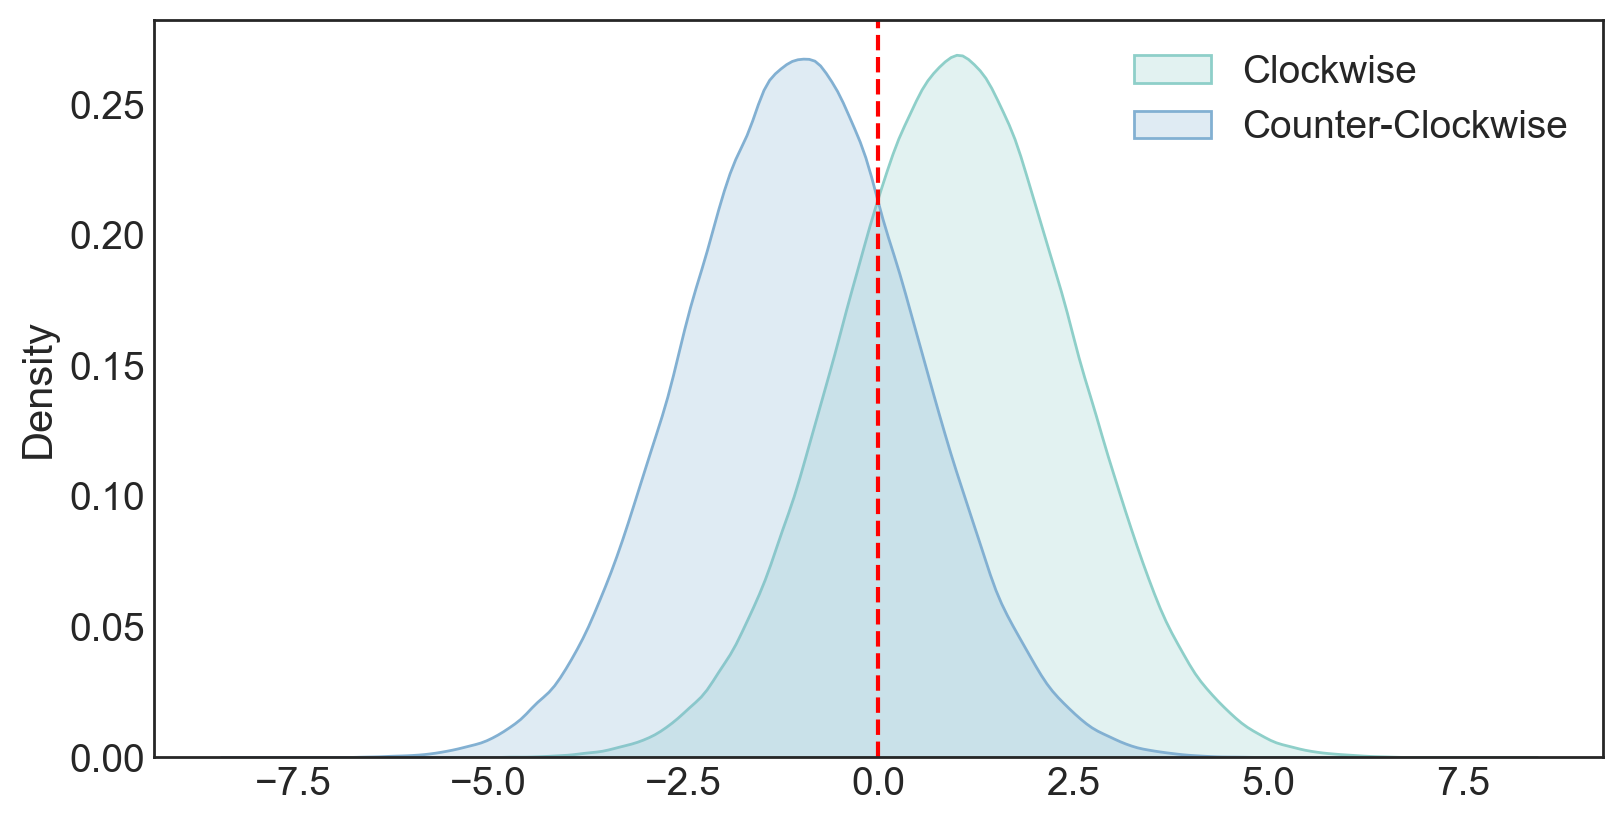

In [13]:
# @title Orientation Judgement under SDT
import numpy as np
import scipy.stats as stats
from scipy.optimize import fsolve
from scipy.optimize import minimize

# We set the hit rate to 0.75 and assume Clockwise is the signal (1:CW, 0:CCW)
Goal_Hit_Prob = 0.75
signal_mean = 1 
noise_mean = -1
criterion = 0 # we assume the criterion is 0.5, since the two orientations are equally likely

# Calculate the most probable common standard deviation
def find_std(std):
    return stats.norm.cdf(criterion, signal_mean, std) - (1 - Goal_Hit_Prob)

rep_times = 10 # the number of times we repeat the optimization to find the best solution
opt_std = []
for irep in range(rep_times):
    std_initial_guess = np.random.uniform(0.1, 1.0)
    std_solution = fsolve(find_std, std_initial_guess)
    opt_std.append(std_solution[0])
common_std = np.mean(opt_std)

# common_std =  1.4826022185056
print('The common standard deviation is: ', common_std)

# Test if this parameter set can generate average hit rate of 0.75
# Generate a set of 10000 random samples from a normal distribution with mean = 1.0, std = common_std
sample_size = 1000000
samples_1 = np.random.normal(signal_mean, common_std, int(sample_size/2))
samples_2 = np.random.normal(noise_mean, common_std, int(sample_size/2))
samples = np.concatenate((samples_1, samples_2), axis=0)
                    
# Calculate the average hit rate and correct rejection rate
hit_rate = np.sum(samples_1 > criterion) / len(samples_1)
print('The average hit rate is: ', hit_rate)
cr_rate = np.sum(samples_2 < criterion) / len(samples_2)
print('The average correct rejection rate is: ', cr_rate)

# Visualize the distributions of the two orientations
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(samples_1, shade=True, color=gr, label='Clockwise')
sns.kdeplot(samples_2, shade=True, color=bl, label='Counter-Clockwise')
plt.axvline(x=criterion, color='r', linestyle='--')
plt.legend()
plt.show()

### 1.2.1 Updating the Prior of the Stimulus

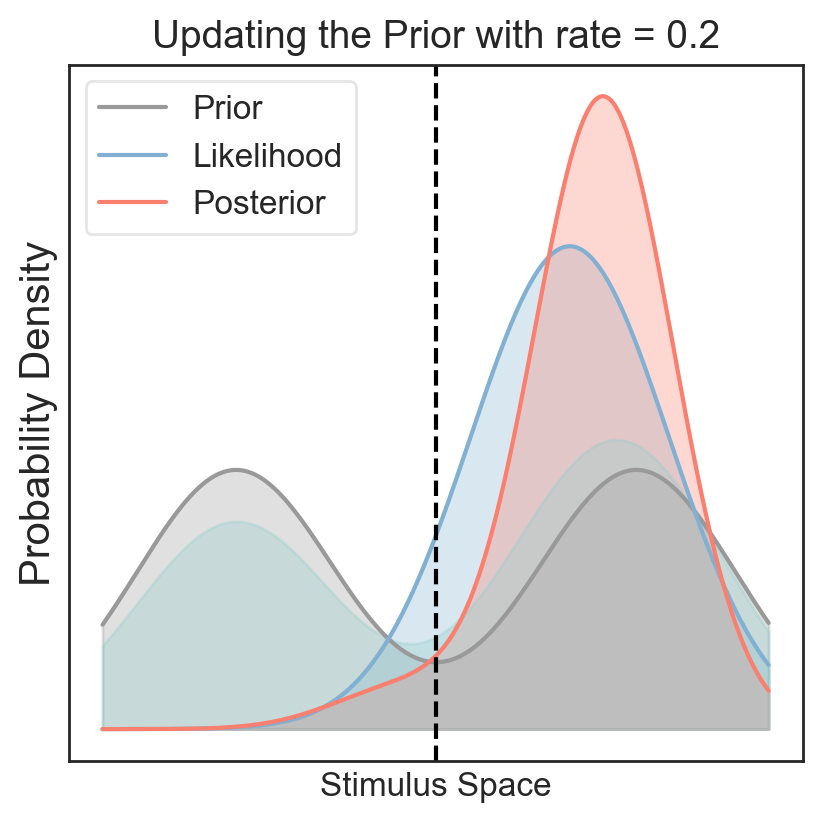

In [11]:
# Construct a bimoal distribution by combining the two gaussian distributions
Goal_Hit_Prob = 0.75
signal_mean = 3
noise_mean = -3
criterion = 0 # we assume the criterion is 0.5, since the two orientations are equally likely
common_std =  1.4826022185056
update_rate = 0.2

total_width = 10
reso = 0.02 # resolution of the x-axis
x = np.arange( 0 - total_width/2, 0 + total_width/2, reso)

# Generate a prior distribution
def init_Prior(x, signal_mean, noise_mean, common_std):
    prior = np.zeros(len(x))
    prior = stats.norm.pdf(x, signal_mean, common_std) + stats.norm.pdf(x, noise_mean, common_std)
    prior = prior / np.sum(prior)
    return prior

# Generate Likeliood distribution for a given stimulus
def Likeliood_i(x, stimulus, common_std):
    likelihood = stats.norm.pdf(x, stimulus, common_std)
    likelihood = likelihood / np.sum(likelihood)
    return likelihood

def Posterior_i(prior_i, likelihood_i):
    posterior_i = prior_i * likelihood_i
    posterior_i = posterior_i / np.sum(posterior_i)
    return posterior_i

def update_Prior_i(prior_i, likelihood_i, update_rate):
    updated_prior = prior_i * (1-update_rate) + likelihood_i * update_rate
    return updated_prior

fig  = plt.figure(figsize=(4,4))

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
s_i = 2
prior = init_Prior(x, signal_mean, noise_mean, common_std)
likelihood = Likeliood_i(x, s_i, common_std)
posterior = Posterior_i(prior, likelihood)
updated_prior = update_Prior_i(prior, likelihood, update_rate)
plt.plot(x, prior, color= ak,label = 'Prior')
plt.plot(x, likelihood, color= bl, label = 'Likelihood')
plt.plot(x, posterior, color= re, label = 'Posterior')
# plt.plot(x, updated_prior, color= gr, label = 'Updated Prior')
plt.legend(loc = 'upper left', fontsize=12, frameon=True, framealpha=0.5), plt.xlabel('Orientation (deg)'), plt.ylabel('Probability Density')
# fill the area under the curve
plt.fill_between(x, prior, color= ak, alpha=0.3)
plt.fill_between(x, likelihood, color= bl, alpha=0.3)
plt.fill_between(x, posterior, color= re, alpha=0.3)
plt.fill_between(x, updated_prior, color= gr, alpha=0.3)
plt.yticks([])
plt.xlim([-total_width/2 - 0.5 , total_width/2 + 0.5])
plt.axvline(x=criterion, color='k', linestyle='--')
plt.tick_params(axis='both', which='major', labelsize=12, direction='in', length=5)
plt.title('Updating the Prior with rate = ' + str(update_rate), fontsize=14)
# plt.title('Bayesian Inference Demo', fontsize=14, fontweight='bold')
plt.xlabel('Stimulus Space', fontsize=12)
plt.xticks([])
plt.show()


### 1.2.2 Trial_update Function

In [16]:
# @title Orientation Judgement under SDT
Goal_Hit_Prob = 0.75
signal_mean = 1 
noise_mean = -1
criterion = 0 # we assume the criterion is 0.5, since the two orientations are equally likely
common_std =  1.4826022185056
update_rate = 0.2


def Bayesian_Per_Trial(x, s_i, s_std, prior, update_rate, criterion):
    likelihood = Likeliood_i(x, s_i, s_std)
    posterior = Posterior_i(prior, likelihood)
    updated_prior = update_Prior_i(prior, likelihood, update_rate)
    # calculate the probability of choosing the signal orientation
    p_signal = np.sum(posterior[x > criterion])
    return likelihood, posterior, updated_prior, p_signal

def Data_Gen(trialnum, 
             signal_mean = signal_mean, noise_mean = noise_mean, std = common_std):
    '''
    Generate data with noise for a given number of trials.
    '''
    samples_1 = np.random.normal(signal_mean, std, int(trialnum/2))
    labels_1 = np.ones(int(trialnum/2))
    samples_2 = np.random.normal(noise_mean, std, int(trialnum/2))
    labels_2 = np.zeros(int(trialnum/2))
    samples = np.concatenate((samples_1, samples_2), axis=0)
    labels = np.concatenate((labels_1, labels_2), axis=0)
    # shuffle the data
    idx = np.arange(trialnum)
    np.random.shuffle(idx)
    samples = samples[idx]
    labels = labels[idx]
    return samples, labels

# simulate a block

total_width = 12
reso = 0.02 # resolution of the x-axis
x = np.arange( 0 - total_width/2, 0 + total_width/2, reso)

trialnum = 50
samples, labels = Data_Gen(trialnum)
Data_sim = pd.DataFrame(columns=['Stimulus', 'Label', 'p(Prior < c)', 'p(Prior > c)', 'p(Posterior < c)', 'p(Posterior > c)', 'Percept', 'Correctness'])

for iT in range(trialnum):
    if iT == 0:
        prior_i = init_Prior(x, signal_mean, noise_mean, common_std)
    else:
        prior_i = updated_prior
    likelihood_i, posterior_i, updated_prior, p_signal_i = Bayesian_Per_Trial(x, samples[iT], common_std, prior_i, update_rate, criterion)    
    
    percept_i = 1 if p_signal_i > 0.5 else 0
    correctness_i = 1 if percept_i == labels[iT] else 0
    Trial_i = pd.DataFrame({'Stimulus': samples[iT], 'Label': labels[iT], 'p(Prior < c)': np.sum(prior_i[x < criterion]), 'p(Prior > c)': np.sum(prior_i[x > criterion]), 'p(Posterior < c)': np.sum(posterior_i[x < criterion]), 'p(Posterior > c)': np.sum(posterior_i[x > criterion]), 'Percept': percept_i, 'Correctness': correctness_i}, index=[iT])
    Data_sim = pd.concat([Data_sim, Trial_i], axis=0)
    
print('The average correctness is: ', np.mean(Data_sim['Correctness']))
Data_sim.head()

The average correctness is:  0.72


,Stimulus,Label,p(Prior < c),p(Prior > c),p(Posterior < c),p(Posterior > c),Percept,Correctness
0,2.633698,1.0,0.502149,0.497851,0.083743,0.916257,1,1
1,-0.001171,0.0,0.409489,0.590511,0.458362,0.541638,1,0
2,-2.414128,0.0,0.428192,0.571808,0.886318,0.113682,0,1
3,-1.587480,0.0,0.532272,0.467728,0.831828,0.168172,0,1
4,-0.411324,0.0,0.597651,0.402349,0.661962,0.338038,0,1


## 2 Combining Bayesian Inference and Reinforcement Learning

### 2.1 The most basic model-free RL

即，在第一个最基本的模型中，我们的被试只对按键左右（action）进行价值积累；前面所涉及的所有，目标朝向和按键 mapping 所构成的状态空间并不被考虑。

#### Mathematical Formulation

**Q**: the value of each action, 1 x 2 vector for LeftKey and RightKey

**Update Rule**: $Q_{t+1}(a_t) = Q_t(a_t) + \alpha \cdot (r_t - Q_t(a_t))$

Since this is a perceptual task, the basic decision rule should be made by choosing the action that indicates the correct orientation of the stimulus.

Due to the threshold-level sensory noise, the observer takes into account the probability of the action being correct, and then makes the decision.

**Utility**: $U_t(a_t) = Q_t(a_t) \cdot p_t(a_t)$

For each trial, the observer caculates the Utility of each action, and then select the action with the highest utility.

**Action Selection**: $a_t = \arg\max_{a_t} U_t(a_t)$

And, we assume that the **Feedback Signal** is already the reward as it is:

**Reward**: $r_t = f_t = \begin{cases} 1 & \text{if correct} \\ 0 & \text{if incorrect} \end{cases}$

In [40]:
def RL_1_per_trial(posterior, mapping, v_L, v_R, label, learning_rate, reward = 1, punishment = 0.7, learning_rate_2 = 0.1):
    '''
    Simulate the Reinforcement Learning process per trial.
    param posterior: the posterior probability of the signal : [\  /], this model is just likelihood
    param mapping: the mapping of the response keys: [\  /] or [/  \], 1 for [\  /] and 2 for [/  \]
    param v_L, v_R: the value of the left and right action
    param label: the label of the stimulus: 1 for CW / and 0 for CCW \ 
    param learning_rate: the learning rate of the RL model
    param reward/punishment: the reward and punishment value for the correct response
    
    Return: 
    action: the action chosen by the model, -1 for left and 1 for right
    resp_ori: the orientation of the response, 1 for CW / and 0 for CCW \ 
    feedback: the feedback given by the environment, 1 for correct and 0 for incorrect
    v_L, v_R: the updated value of the left and right action
    '''
    key_mapping = {-1: [0, 1], 1: [1, 0]}
    
    if mapping == 1:
        U_L = posterior[0] * v_L
        U_R = posterior[1] * v_R
    else:
        U_L = posterior[1] * v_L
        U_R = posterior[0] * v_R
    
    # choose the action with the larger utility and receive the feedback
    action = np.sign(U_R - U_L)
    resp_ori = key_mapping[action][mapping-1]
    feedback = int(resp_ori == label)
    r = reward if feedback else punishment
    r_fic = punishment if feedback else reward
    
    # update the value of the chosen action
    if action == -1:
        v_L += learning_rate * (r - v_L)
        v_R += 0.02
    else:
        v_R += learning_rate * (r - v_R)
        v_L += 0.02
    
    return action, resp_ori, feedback, v_L, v_R

Exploration alhorithm

In [41]:
## simulate a subject with 20 block for Bayesian + RL model

# set the parameters
subjnum = 30
trialnum = 50
blocknum = 20

signal_mean = 1 
noise_mean = -1
criterion = 0 # we assume the criterion is 0.5, since the two orientations are equally likely
common_std =  1.4826022185056

update_rate = 0.2
total_width = 12
reso = 0.02 # resolution of the x-axis
x = np.arange( 0 - total_width/2, 0 + total_width/2, reso)

learning_rate = 0.2
reward = 1
punishment = 0
init_value = 0.5

# simulate the subject
Data_sim = pd.DataFrame(columns=['Subject', 'Block', 'Trial',
    'Stimulus', 'Label', 'p(Prior < c)', 'p(Prior > c)', 'p(Posterior < c)', 'p(Posterior > c)', 'Percept', 
    'Action', 'Resp_ori', 'Correctness', 'v_L', 'v_R', 'Mapping'])

for iS in range (1, subjnum + 1):
    for iB in range(1, blocknum + 1):
        samples, labels = Data_Gen(trialnum)
        for iT in range(trialnum):
            if iT == 0:
                prior_i = init_Prior(x, signal_mean, noise_mean, common_std)
                v_L = init_value
                v_R = init_value
            else:
                prior_i = updated_prior
                v_L = v_L_i
                v_R = v_R_i
            likelihood_i, posterior_i, updated_prior, p_signal_i = Bayesian_Per_Trial(x, samples[iT], common_std, prior_i, update_rate, criterion)    
            
            percept_i = 1 if p_signal_i > 0.5 else 0
            pos_decision_i = [np.sum(posterior_i[x < criterion]), np.sum(posterior_i[x > criterion])]
            
            # choose the mapping
            mapping_i = np.random.choice([1, 2])
            # choose the action and receive the feedback
            action_i, resp_ori_i, feedback_i, v_L_i, v_R_i = RL_1_per_trial(pos_decision_i, mapping=mapping_i, v_L=v_L, v_R=v_R, label=labels[iT], learning_rate=learning_rate, reward=reward, punishment=punishment)
            
            Trial_i = pd.DataFrame({'Subject': iS, 'Block': iB, 'Trial': iT +1,
                'Stimulus': samples[iT], 'Label': labels[iT], 'p(Prior < c)': np.sum(prior_i[x < criterion]), 'p(Prior > c)': np.sum(prior_i[x > criterion]), 'p(Posterior < c)': np.sum(posterior_i[x < criterion]), 'p(Posterior > c)': np.sum(posterior_i[x > criterion]), 'Percept': percept_i, 
                'Action': action_i, 'Resp_ori': resp_ori_i, 'Correctness': feedback_i, 'v_L': v_L, 'v_R': v_R, 'Mapping': mapping_i}, index=[iT])
            Data_sim = pd.concat([Data_sim, Trial_i], axis=0)
        

In [42]:
# Reorganize the data for Serial Dependence analysis
trial_template = pd.DataFrame(columns=['StimSeq', 'RespOri', 'RespLorR', 'Accuracy', 'ProbeOriLeft', 'ProbeOriRight', 'Qualified'])
all_data = {}

for iS in range(1, subjnum + 1):
    subject_data = []
    raw_subj = Data_sim[Data_sim['Subject'] == iS]
    for iB in range(1, blocknum + 1):
        block_data = raw_subj[raw_subj['Block'] == iB]
        temp_data = trial_template.copy()
        temp_data['StimSeq'] = block_data['Label'].values.copy()
        temp_data['StimSeq'].replace({0: -45, 1: 45}, inplace=True)
        temp_data['RespOri'] = block_data['Resp_ori'].values.copy()
        temp_data['RespOri'].replace({0: -45, 1: 45}, inplace=True)
        temp_data['RespLorR'] = block_data['Action'].values.copy()
        temp_data['Accuracy'] = block_data['Correctness'].values.copy()
        temp_data['ProbeOriLeft'] = block_data['Mapping'].values.copy()
        temp_data['ProbeOriLeft'].replace({1: -45, 2: 45}, inplace=True)
        temp_data['ProbeOriRight'] = block_data['Mapping'].values.copy()
        temp_data['ProbeOriRight'].replace({1: 45, 2: -45}, inplace=True)
        temp_data['Qualified'] = True
        subject_data.append(temp_data)
    all_data[iS] = subject_data
    
def criterion(hit, FA):
    return -0.5*(stats.norm.ppf(hit) + stats.norm.ppf(FA))

def dprime(hit, FA):
    return (stats.norm.ppf(hit) - stats.norm.ppf(FA))/np.sqrt(2)

def hit_fa(df):
    hit = df[(df['StimSeq'] == 45)]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == -45)]['Accuracy']
    return hit, fa

def hit_fa_motor(df):
    hit = df[(df['StimSeq'] == df['ProbeOriRight'])]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == df['ProbeOriLeft'])]['Accuracy']
    return hit, fa

In [43]:
def process_data_percept_cb(data, back):
    """Return hits and false alarms for a specific n-back"""
    hit, fa = hit_fa(data[(data['RespOri'].shift(back) == 45) & (data['Qualified'] == True)])
    hit_n, fa_n = hit_fa(data[(data['RespOri'].shift(back) == -45) & (data['Qualified'] == True)])
    return (hit, fa, hit_n, fa_n)

def calculate_sd_nback_percept_cb(all_data):
    maxsubj = 30; maxblock = 20; maxtrial = 50; num_backs = 10
    SD_nback_Percept_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

    for iS in range(1, maxsubj + 1):
        subject_data = all_data[iS]
        temp_data = {f"{i}_back": {"Hit": [], "FA": [], "Hit_n": [], "FA_n": []} for i in range(1, num_backs + 1)}

        for iB in range(1, maxblock + 1):
            for back in range(1, num_backs + 1):
                block_data = subject_data[iB - 1]
                hits_fa = process_data_percept_cb(block_data, back)
                temp_data[f"{back}_back"]["Hit"].append(hits_fa[0])
                temp_data[f"{back}_back"]["FA"].append(hits_fa[1])
                temp_data[f"{back}_back"]["Hit_n"].append(hits_fa[2])
                temp_data[f"{back}_back"]["FA_n"].append(hits_fa[3])

        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits = np.concatenate(temp_data[key]["Hit"])
            fas = np.concatenate(temp_data[key]["FA"])
            hits_n = np.concatenate(temp_data[key]["Hit_n"])
            fas_n = np.concatenate(temp_data[key]["FA_n"])
            cs = criterion(np.mean(hits_n), np.mean(fas_n)) - criterion(np.mean(hits), np.mean(fas))
            SD_nback_Percept_cb[key].append(cs)

    return pd.DataFrame(SD_nback_Percept_cb)


def process_data_motor_cb(data, back):
    """Return hits and false alarms for motor responses"""
    hit_L, fa_L = hit_fa_motor(data[(data['RespLorR'].shift(back) == -1) & (data['Qualified'] == True)])
    hit_R, fa_R = hit_fa_motor(data[(data['RespLorR'].shift(back) == 1) & (data['Qualified'] == True)])
    return (hit_L, fa_L, hit_R, fa_R)

def calculate_sd_nback_motor_cb(all_data):
    maxsubj = 30; maxblock = 20; num_backs = 10
    SD_nback_Motor_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

    for iS in range(1, maxsubj + 1):
        subject_data = all_data[iS]
        temp_data = {f"{i}_back": {"Hit_L": [], "FA_L": [], "Hit_R": [], "FA_R": []} for i in range(1, num_backs + 1)}

        for iB in range(1, maxblock + 1):
            for back in range(1, num_backs + 1):
                block_data = subject_data[iB - 1]
                hits_fa = process_data_motor_cb(block_data, back)
                temp_data[f"{back}_back"]["Hit_L"].append(hits_fa[0])
                temp_data[f"{back}_back"]["FA_L"].append(hits_fa[1])
                temp_data[f"{back}_back"]["Hit_R"].append(hits_fa[2])
                temp_data[f"{back}_back"]["FA_R"].append(hits_fa[3])

        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits_L = np.concatenate(temp_data[key]["Hit_L"])
            fas_L = np.concatenate(temp_data[key]["FA_L"])
            hits_R = np.concatenate(temp_data[key]["Hit_R"])
            fas_R = np.concatenate(temp_data[key]["FA_R"])
            cs = criterion(np.mean(hits_L), np.mean(fas_L)) - criterion(np.mean(hits_R), np.mean(fas_R))
            SD_nback_Motor_cb[key].append(cs)

    return pd.DataFrame(SD_nback_Motor_cb)

SD_nbacks_Percept = calculate_sd_nback_percept_cb(all_data)
SD_nbacks_Motor = calculate_sd_nback_motor_cb(all_data)

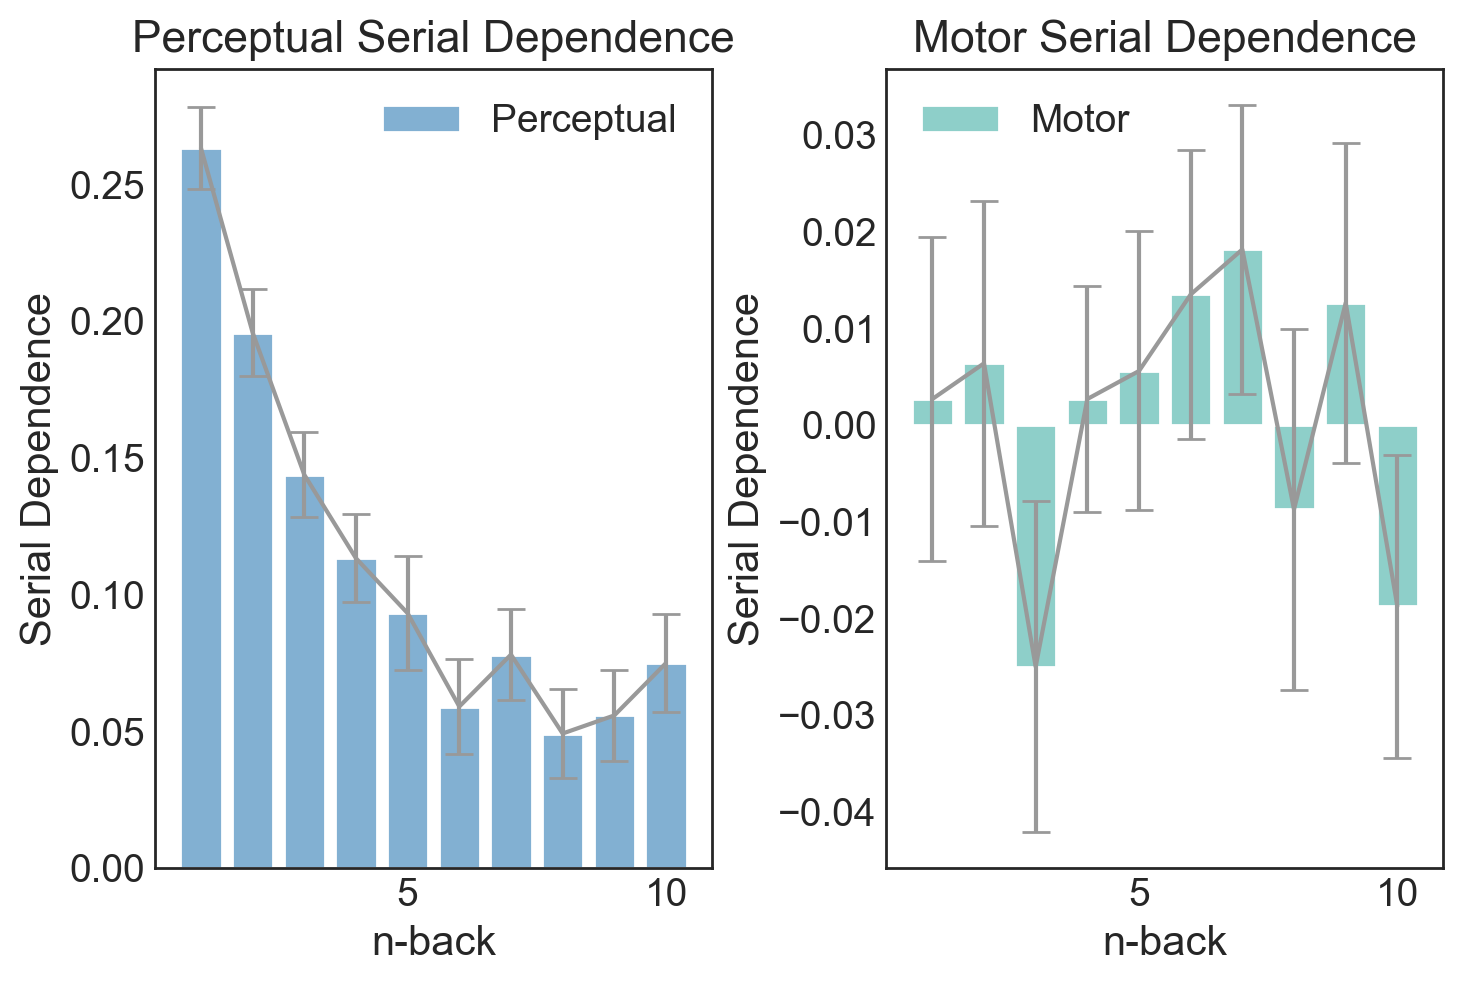

In [44]:
plt.subplot(1,2,1)
maxsubj = 30
plt.bar(np.arange(1, 11), SD_nbacks_Percept.mean(axis=0), color=bl, label='Perceptual')
plt.errorbar(np.arange(1, 11), SD_nbacks_Percept.mean(axis=0), yerr=SD_nbacks_Percept.std(axis=0)/np.sqrt(maxsubj), color = ak, capsize=5)
plt.xlabel('n-back')
plt.ylabel('Serial Dependence')
plt.title('Perceptual Serial Dependence')
plt.legend()
plt.subplot(1,2,2)
plt.bar(np.arange(1, 11), SD_nbacks_Motor.mean(axis=0), color=gr, label='Motor')
plt.errorbar(np.arange(1, 11), SD_nbacks_Motor.mean(axis=0), yerr=SD_nbacks_Motor.std(axis=0)/np.sqrt(maxsubj), color = ak, capsize=5)
plt.xlabel('n-back')
plt.ylabel('Serial Dependence')
plt.title('Motor Serial Dependence')
plt.legend()
plt.show()